# Convolutional Neural Networks

Convolutional Neural Networks (CNNs) began from the study of the brain's visual cortex. Due to the increase in computational power and available training data over the last few years, computers are now able to perform complex visual tasks, voice recognition and natural language processing. 

This notebook will focus on:

- CNN Architecutures
- Object Detection: Classifiying objects + boundary boxes.
- Semantic Segmentation: Classifiying pixels based on the objects they belong to.

It is obvious that the brain reacts to visual stimuli. However, it was discovered that neurons within the visual cortex has a local receptive field, meaning some neurons react to certain orientations of lines and while others react to more complex patterns where those neurons have a larger receptive field.

The __architecture__ of a CCN consists of lower level neurons which respond to small receptive fields (such as lines) and the neighboring outputs of these neurons are the inputs of the higher level neurons respond to larger receptive fields. Furthermore, all neurons are not connected but only locally connected by introducing partially connected layers and weight sharing - __not all neurons are connected to each pixel from the input image, rather only the receptive field__. 

Comparing the neural network architectures that we have seen previously, we know that for larger images having a fully connected layer will signifcantly slow training and restricts information transmitted into the next layer. With CNNs we do not require the input_shape to be flattened into a 1D vector but rather can a 2D (later we will see that this can be split into RGB or Grey scale - making the neural network more accurately represented as a 3D matrix). 

The CCN architecture allows the small low level features to be learned in the first hidden layer and later assemble into larger higher level features in the next hidden layer. 





In [1]:
# typical imports 
from functools import partial
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
%tensorflow_version 2.x #  required only for google collab

# set random seed
np.random.seed(42)
tf.random.set_seed(42)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x #  required only for google collab`. This will be interpreted as: `2.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


In [2]:
assert tf.__version__ > "2.0" #  check version
tf.__version__

'2.5.0'

### __Receptive Fields__
The receptive field is defined by $f_h$ and $f_w$ which represents the field height and width. 

### __Zero Padding__
It is common to add zeros around the inputs (i.e. the image itself) to preserve the height and width of the previous layer with the CNN. 

### __Stride__
To reduce dimensionality of the upper layers we can introduce a Stride. Concretely, the shift from one receptive field to the next. The Stride is defined as, $s_h$ and $s_w$, which represents the Stride height and width. By increasing the Stride we reduce computational complexity.

### __CNN Layer__
Hence, the upper layer neuron located at row $i$ and column $j$ is connected to the previous layers neurons connected to rows $i$ x $s_h$ to $i$ x $s_h + f_h - 1$ and columns $j$ x $s_w$ to $j$ x $s_w + f_w - 1$. 

__note__ It does not matter if you do not completely understand the above. Just know that the two building blocks of CNNs are convolutional layers and pooling layers. 

# Convolutional Layers
### __Filters/Convolutional Kernels__

The filters can be thought of as neuron's weights which can be represented as the size of the receptive field.

Below, I create two filters, a vertical and horizontal line, These filters will change the weights accordingly. Neurons using these weights will ignore everything apart from the vertical and horizontal lines. 

In [3]:
# create filters/ convolutional kernels
filters = np.zeros(shape=(7, 7, 3, 3), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

# set last filter to identify matrix
filters[:, :, 0, 2] = np.identity(7)
filters[:, :, 1, 2] = np.identity(7)
filters[:, :, 2, 2] = np.identity(7)

print(filters[:, :, 0, 0], end='\n\n\n\n',)  #  vertical 1s
print(filters[:, :, 0, 1], end='\n\n\n\n',)  #  horizontal 1s
print(filters[:, :, 0, 2])  #  identity matrix

[[0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]]



[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]



[[1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1.]]


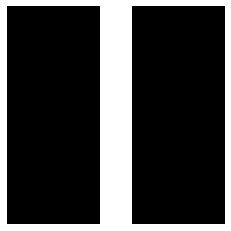

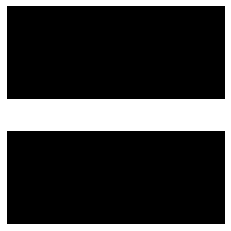

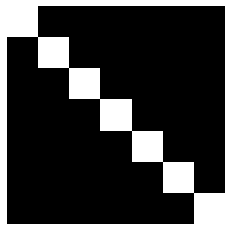

In [4]:
# make a function
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")
    plt.show()

plot_image(filters[:, :, 0, 0])
plot_image(filters[:, :, 0, 1])
plot_image(filters[:, :, 0, 2])

__Filters are the same size as the images receptive field__. The above filters can also be thought of as weights, where the white line is 1 and the black line is 0. These weights will ignore everything apart from the 1s. If we used the same __vertical filter, above, on an image we will enhance all vertical white lines__ within an image. Meanwhile, using the __horizontal filter we will enhance all hortizontal white lines within an image__. 


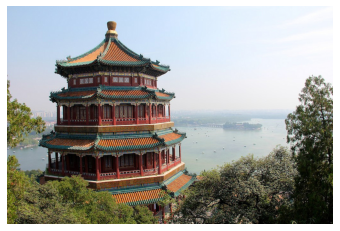

In [5]:
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg") / 255.

def plot_color_image(image):
  plt.imshow(image, cmap='gray')
  plt.axis('off')
  plt.show()

plot_color_image(china)

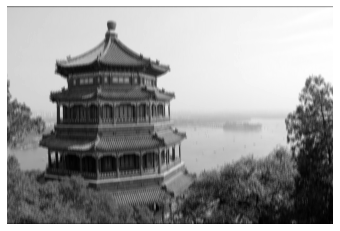

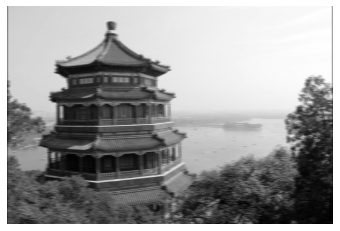

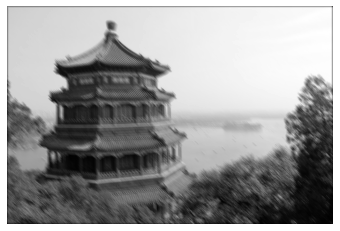

In [6]:
outputs = tf.nn.conv2d( np.array([[china, china]]), filters, strides=1, padding="SAME")
plot_color_image(outputs[0, 0, :, :, 0])
plot_color_image(outputs[0, 0, :, :, 1])
plot_color_image(outputs[0, 0, :, :, 2])

There does not seem to be anything obvious about what the filters have done but zooming in closer we can see that the vertical, horizontal and diagonal lines have been enhanced.

#### __Output of Filters__
The output of the filters, called a feature map, highlights area which activates the filter the most. During training the CNN will automatically learn the most useful filters and the layers above combine them to more complex patterns.

In [7]:
def crop(images):
    return images[200:250, 150:250]

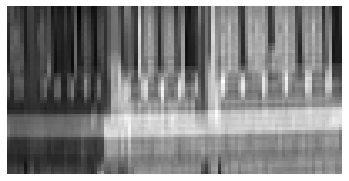

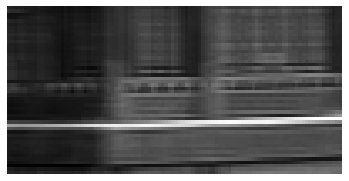

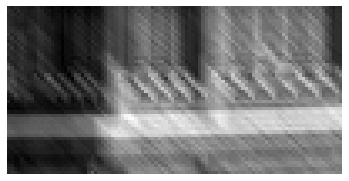

In [8]:
plot_color_image(crop(outputs[0, 0, :, :, 0])) #  vertical lines are enhanced
plot_color_image(crop(outputs[0, 0, :, :, 1])) #  horizontal lines are enhances
plot_color_image(crop(outputs[0, 0, :, :, 2])) #  diagonal lines are enhanced

# the below images are called feature maps. They are produced when you apply
# filters.

### __Stacking Multiple Feature Maps__


Typically, a CNN layer contains multiple trainable filters (i.e. the vertical/ horizontal/ diagonal filters above), where the CNN learns the most useful filters. The output being one feature map per filters but in 3D. All neurons within a feature map share the same parameters - bias and weight terms - and different feature maps do not share the same parameters. The benefit of sharing the parameters allows the CCN to learn and recognise patterns anywhere within an image while a deep neural network (DNN) will only be able to learn and recognise a pattern locally. 

All neurons from a CNN layer's feature map is connected to the outputs of the exact same neurons in the previous layer. Putting this into a formula gives the following: 

$ z_{i, j, k} = b_k + \sum^{f_h - 1}_{u = 0} \sum^{f_w - 1}_{v = 0} \sum^{f_{n'} - 1}_{k' = 0} x_{i', j', k'}. w_{u, v, k', k}$

Think of it like __$ z = b + Xw$__, 
- where $z$ is the output of the neuron located in some row and column of a CNN layer's, $l$, feature map $k$.
- $b$ is the bias term, think of this as a term being used to increase the brightness of the feature map $k$.
- $w$ is the connection weight between the neuron and feature map $k$ of the layer $l$ located at row $u$ and column $v$, and feature map $k'$. 
- $x$ is the output of the previous layer's, $l-1$, feature map, $k'$, located at row $i'$ and column $j'$. 

## Tensorflow Implementation 

An image is given as a matrix as: __height, width, channel.__ 

A dataset containing several pictures has shape: __Batch size, height, width, channel.__

The weights and bias term matrix for CNN are determined by the shape of the receptive field, and will be a 4D tensor of shape $f_h, f_w, f_{n'}, f_n$, where $f_n$ is the bias term. 

In [9]:
from sklearn.datasets import load_sample_image #  load another shape file

flower = load_sample_image('flower.jpg')/255.
assert flower.shape == china.shape #  same shape and size images

In [10]:
flower.shape #  height, width, channels (RGB)

(427, 640, 3)

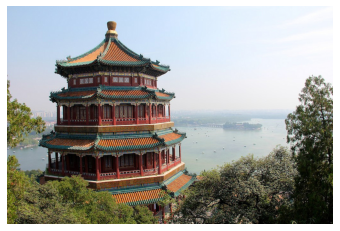

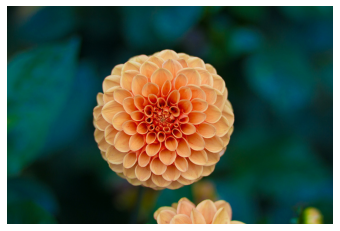

In [11]:
plot_color_image(china)
plot_color_image(flower)

Images require preprocessing, as RGB (and gray values) range in intensity from 0 to 255, we need to obtain floats ranging from 0 to 1 by dividing through by 255.

In [12]:
images = np.array([china, flower])
(batchsize, height, width, channels) = images.shape

Use horizontal and vertical filters from earlier. 

In [13]:
# create filters/ convolutional kernels
filters = np.zeros(shape=(7, 7, channels, 3), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

# set last filter to identify matrix
filters[:, :, 0, 2] = np.identity(7)
filters[:, :, 1, 2] = np.identity(7)
filters[:, :, 2, 2] = np.identity(7)



### Using tf.nn.con2d - Tensorflows low level Deep Learning API

The output of tf.nn.conv2d produces feature maps based on the input filters.

The input ```filters``` argument are the set of filters applied to each image within the dataset - this also needs to be a 4D tensor. 

The ```strides``` argument is the stride to be used. It can also be 1D array specifying the vertical ($s_h$) and horizontal ($s_w$) strides. 

The ```padding``` argument takes either "SAME" or "VALID". 
- "SAME" introduces padding to the input if required, the output's will be divided by the stride. So increasing the string with normal produces a more pixelated image. For example, input size of 15 and stride of 3 gives a vector of 5, however, if stride is 1 then the output size is the "SAME" - hence, the name. 

- "VALID" does not introduce padding to the input and will ignore some rows and columns at the bottom and right of the image if required. The neurons receptive field does not go out of bounds (i.e. does not introduce zero padding) and strictly stays within the "VALID" positions - hence, the name.

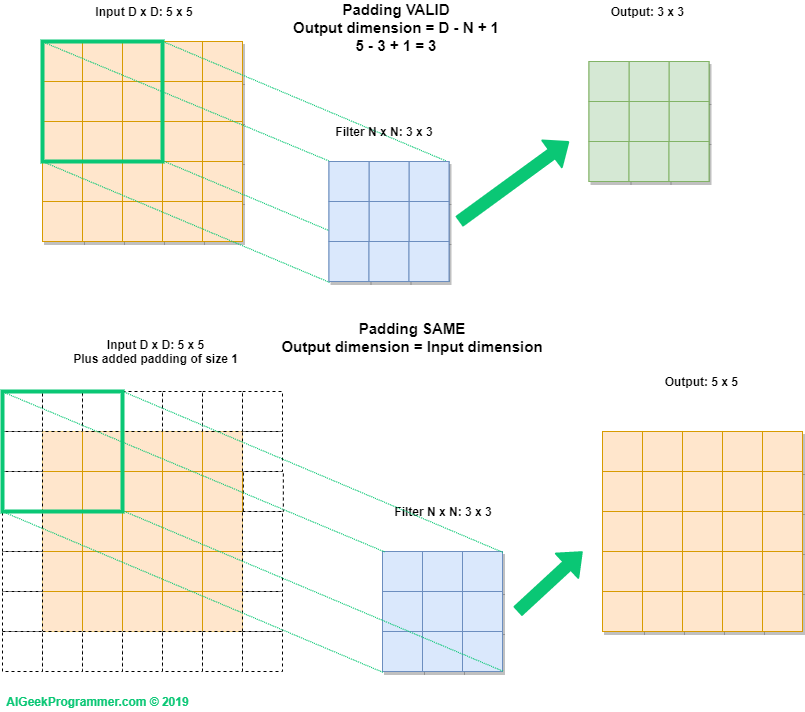

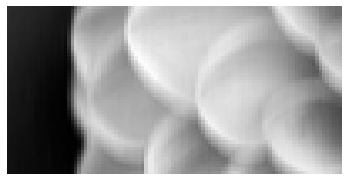

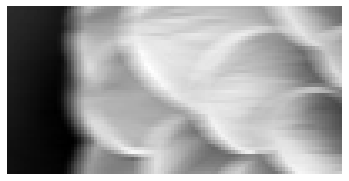

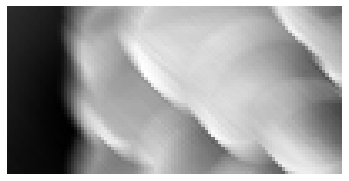

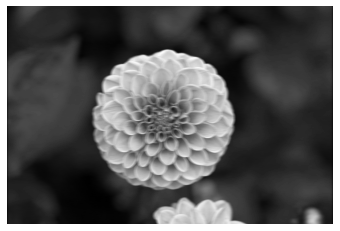

In [14]:
# Apply filters to both images. 
# Use SAME padding and a stride of 1. 
# outputs feature maps
output = tf.nn.conv2d(input=images, filters=filters, strides=1, padding='SAME')
plot_color_image(crop(output[1, :,:, 0])) #  vertical filter
plot_color_image(crop(output[1, :,:, 1])) #  horizontal filter
plot_color_image(crop(output[1, :,:, 2])) #  horizontal filter
plot_color_image((output[1, :, :, 1]))

### keras.layers.Conv2D

In reality, using Tensorflows tf.nn.conv2d is unlikely and using manually defined filters is far from ideal. A far better approach would be to have filters that have trainable variables.

In the code below we create 32 filters of kernel_size (in this case 3x3, it can also be a 1D array) with "same" padding type. There are many more hyperparameters that will require tuning but there are many "off the shelf" models available. 

In [15]:
conv = keras.layers.Conv2D( 
    filters=32,  # trainable filters
    kernel_size=3, #  receptive field size
    strides=1,  # stride size for receptive field
    padding="same",  # choose type of padding: SAME or VALID
    activation="relu"  # activate function
    )

####Memory Requirements for Convolutional Layers

As you can gather by now, convolutional layers require a lot of RAM, especially during training and as you apply more filters into the mix. This can be an issue as parameters need to stay in RAM during backpropagation. During inferenace (i.e. when making predictions for new instances), the RAM occupied by one layer can be released as soon as the next layer has been computed - only 2 consecutive layers need to fit in RAM.

If you run into an `out of memory error` then try reducing the batch size, filters, layers, or converting 32-bit floats to 16-bit floats, otherwise try to increase stride. 

# Pooling Layers

Convolutional layers require a lot of RAM, as described above, which is why Pooling layers where invented. Pooling layers have a goal to shrink the input image in order to reduce computational load, memory usage and therefore, number of parameters - which also implies reducing the risk of overfitting.

Pooling layers introduces some level of invariance (i.e. no/minimal change) to small translations. It offers small invariance to rotational translations and scale. Meaning if an input image is translated (moved) then the pooling layers benefit causes invariance which will prevent much change from being observed in the output layer.   


#### How does it work?

A pooling layer applies an aggeration function, for example, mean, max, median etc. to a receptive field. It aggregates the values within the receptive field and returns a single value. The layer does not have weights. As there is a receptive field, that also means there is a stride. With a stride of 2 we will half the height and width in the output image. 

#### Problem
Max pooling layers are a popular type of pooling layer. They can be very destructive in some applications, where invariance is not desirable. For example, if you need to classify a pixel belonging to a certain object. If the input image has been translated then we would like the output image to translate that pixel also. In these instances, we require equivariance - small change leads to a corrosponding change.  


In [16]:
#  tensorflow implementation of pooling
max_pool = keras.layers.MaxPool2D(pool_size=(2,2))

In [17]:
x = tf.constant([[1., 2., 3., 4.],
                 [5., 6., 7., 8.],
                 [9., 10., 11., 12.],
                 [4., 19., 32., 43.]])

x = tf.reshape(x, [1, 4, 4, 1])

In [18]:
# output is as expected
tf.reshape(max_pool(x), [2,2])

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[ 6.,  8.],
       [19., 43.]], dtype=float32)>

In [19]:
cropped_images = np.array([crop(image) for image in [china, flower]], dtype=np.float32)
output = max_pool(cropped_images)

Previous image before pooling:


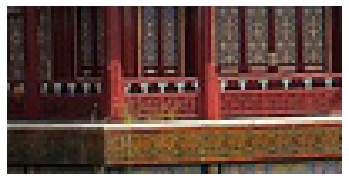

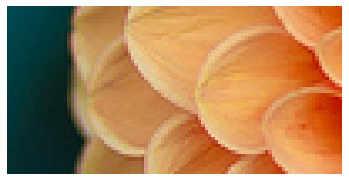

After max pooling:


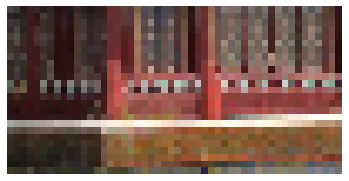

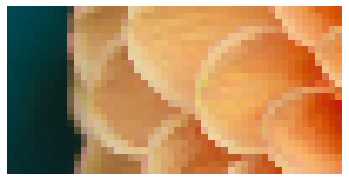

[None, None]

In [20]:
print("Previous image before pooling:")
[plot_color_image(image) for image in cropped_images]
print("After max pooling:")
[plot_color_image(image) for image in output]

As you would expect the images appear more pixelated after applying pooling. The Keras API also has AvgPool2D, which used to be popular but Max pooling tends to work better due to its stonger translational invariance. 

Pooling can be made to work depthwise too, where the pooling layer would ensure the output is the same regardless of the rotation. For example, it could learn from multiple filters (i.e. rotation) and pooling will still output the same value regardless. 

CNNs can learn to be invariant to anything: rotation, thickness, brightness, skew, color, and so on. 

In [21]:
# to implement a depth-wise max pooling layer
# you can use tensorflow

# insert low level tensorflow pooling API in Lambda layer
depthwise_pooling = keras.layers.Lambda(lambda X: tf.nn.max_pool(
    X,
    ksize=(1, 1, 1, 3),  # batch, height, width, depth
    strides=(1, 1, 1, 3),  # ditto
    padding="VALID"))  # no padding at all)

After depth-wise max pooling:


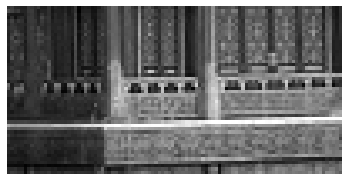

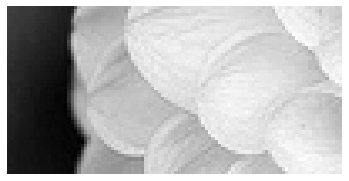

In [22]:
print("After depth-wise max pooling:")


plot_color_image(tf.reshape(depthwise_pooling(cropped_images)[0], [50,100]))
plot_color_image(tf.reshape(depthwise_pooling(cropped_images)[1], [50,100]))

# note how the images all become black and white 

After Average pooling:


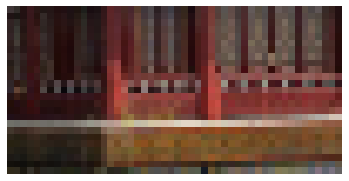

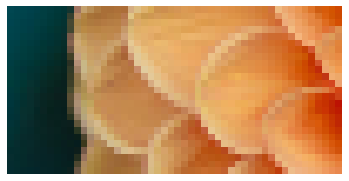

In [23]:
avg_pool = keras.layers.AvgPool2D(pool_size=2)
output_avg = avg_pool(cropped_images)

print("After Average pooling:")

plot_color_image(output_avg[0])
plot_color_image(output_avg[1])

# CNN Architectures

CNN Architectures stack Convolutional layers together, each followed by a ReLU layer, then a Pooling Layer then fully connected layers (+ReLU layers) and then another Pooling layer and so on. The architecture does vary as we will see with the most popular architectures: 

1. LeNet-5: introduced convolutional + pooling layers
2. AlexNet: introduced stacked convolutional + data augmentation
3. GoogleLeNet: introduced inception modules
4. VGGNet: showed that simple architectures work
5. ResNet: introduced skip connections and residual learning
6. Xception: introduced depthwise seperable convolution layer
7. SENet: introduces Squeeze and Excitation block

Typically, the image gets smaller and smaller as it progresses through the network but deeper and deeper with more feature maps in the Convlutional layers. 

Convolution --> ReLU --> Pooling --> Convolution --> Pooling --> Fully Connected Layers (+ReLU) --> Prediction (i.e. Softmax) of class probabilities. 

_Note, unlike fully connected layers, you should avoid using convultional layers that are too large. Instead stack the 2 layers with smaller kernels. It will contain fewer parameters and computations while performing better._ 

# Fashion MNIST with a basic CNN architecture

In [24]:
# load MNIST data
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

# check data shape
assert X_train_full.shape == (60000, 28, 28)
assert X_test.shape == (10000, 28, 28)
assert y_train_full.shape == (60000,)
assert y_test.shape == (10000,)

4423680/4422102 [==============================] - 0s 0us/step


In [25]:
# create validation set
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

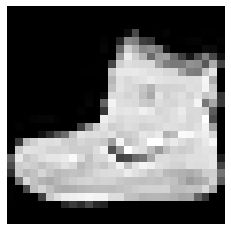

In [26]:
plot_color_image(X_train[0])

In [27]:
# standard scale datasets

# calculate means and standard deviation across all instances
X_means = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7

assert X_means.shape == (1, 28, 28)
assert X_std.shape == (1, 28, 28)

# scale training, validation and testing datasets
X_train = (X_train - X_means) / X_std
X_valid = (X_valid - X_means) / X_std
X_test = (X_test - X_means) / X_std

# Con2D requires input shape to be in 4D 
# (batch-size, width, height, channels)
# in our case channels is 1 as it is a grayscale image
X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test  = X_test[..., np.newaxis]

assert X_train[0].shape == (28, 28, 1)

In [28]:
from functools import partial

# use partial as there standards args within the Convolution neural network

MyConv2D = partial(keras.layers.Conv2D,
                   activation='relu',
                   padding='SAME',
                   kernel_size=3
                   )


model = keras.models.Sequential([
    MyConv2D(input_shape=[28, 28, 1], filters=64, kernel_size=7),
    keras.layers.MaxPooling2D(pool_size=2),
    MyConv2D(filters=128),
    MyConv2D(filters=128),
    keras.layers.MaxPool2D(pool_size=2),
    MyConv2D(filters=256),
    MyConv2D(filters=256),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Flatten(),  # dense layers expect a 1D array
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),  # used to reduce overfitting
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax'),
])

Notice how the number of filters doubles after each pooling layer. This is because the pooling layer reduces the dimensionality of the CNN by half. We can then double the number of feature maps without worrying about memory usage or computational load.

Doubling the number of filters makes sense as it allows us to combine the low-level features to higher-level features.  

*note: the code below will take a long time if you set `epochs=10`, I have set `epochs=1` just so you don't wait a long time when running the notebook yourself*.  :)

In [29]:
model.compile(optimizer='nadam',
              loss=keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])
early_callback = tf.keras.callbacks.EarlyStopping(
    monitor='accuracy', patience=3)

history = model.fit(X_train, y_train,
                    validation_data=(X_valid, y_valid),
                    epochs=1,  # change this 10
                    batch_size=32,
                    callbacks=[early_callback]
          )

1719/1719 [==============================] - 752s 436ms/step - loss: 0.7201 - accuracy: 0.7491 - val_loss: 0.3927 - val_accuracy: 0.8548


In [30]:
score = model.evaluate(X_test, y_test)

313/313 [==============================] - 33s 107ms/step - loss: 0.4069 - accuracy: 0.8597


In [31]:
# score
for metric_name, metric_score in zip(model.metrics_names, score):
  print(f'{metric_name}: {metric_score: 2f}') 

loss:  0.406873
accuracy:  0.859700


Not a bad score given that this was a basic CNN architecture. A model accuracy of 90+% (if you chose to ran it for 10 epochs), which is more than what you would get for the Deep Neural Network (DNN). Most neural networks will be similiar to the one above. But over the last few years architectures have improved and there the error rate has dropped massively. Entries for the famous ILSVRC ImageNet challenge has seen error rate drop from 26% to less than 2.3% over 6 years.  

Understanding these architectures will aid in solidifying how CNNs work. 

## LeNet-5

This architecture was developed by Yann LeCunn in 1998 and is the most widely known CNN architecture. 

Without bogging into the detail of the network, it does differ, Notably, the following: 
- Input layer is the only layer that uses zero-padding, allowing the size of the image as it progresses through the network.
- Values are normalized to a mean of zero and std of 1. 
- Pooling layers computes the mean, followed by a multiplication of a learnable coefficient and adds a learnable bias term - all of which are unique to a map - before applying the activation function.
- Neurons from the Convolution layers are connected to 3/4 of the maps from the layer before.
- Output layer differs as it calculates the euclidian distance between the input vector and its weight vector. The preferred method now is cross entropy cost function, as it penalizes bad predictions much more therefore, penalizing producing large gradients and converging faster. 

A great visual: http://yann.lecun.com/exdb/lenet/index.html

In [32]:
# load MNIST data
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

# create validation set
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

# pad the output so the shape is 32 x 32 - as that is the input of LeNet
# 255 to normalize the values.
X_train = tf.pad(X_train, [[0, 0], [2,2], [2,2]])/255
X_valid = tf.pad(X_valid, [[0, 0], [2,2], [2,2]])/255
X_test = tf.pad(X_test, [[0, 0], [2,2], [2,2]])/255

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test  = X_test[..., np.newaxis]

In [33]:
keras.backend.clear_session()

model = keras.models.Sequential([
    keras.layers.Conv2D(filters=6,
                        kernel_size=(5, 5), activation='tanh',
                        input_shape=(32,32,1), padding='VALID'),
    keras.layers.AveragePooling2D(strides=2),
    keras.layers.Activation('tanh'),
    keras.layers.Conv2D(filters=16, kernel_size=(5, 5), activation='tanh'),
    keras.layers.AveragePooling2D(strides=2),
    keras.layers.Activation('tanh'),
    keras.layers.Conv2D(filters=120, kernel_size=(5, 5), activation='tanh'),
    keras.layers.Flatten(),  # dense layers expect a 1D array
    keras.layers.Dense(84, activation='relu'),
    keras.layers.Dense(10, activation='softmax'),
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 6)         156       
_________________________________________________________________
average_pooling2d (AveragePo (None, 14, 14, 6)         0         
_________________________________________________________________
activation (Activation)      (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
average_pooling2d_1 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
activation_1 (Activation)    (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 120)         4

In [34]:
model.compile(optimizer='nadam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_callback = tf.keras.callbacks.EarlyStopping(
    monitor='accuracy', patience=3)

history = model.fit(X_train, y_train,
                    validation_data=(X_valid, y_valid),
                    epochs=10, 
                    batch_size=64,
                    callbacks=[early_callback]
          )

Epoch 1/10
860/860 [==============================] - 30s 34ms/step - loss: 0.5800 - accuracy: 0.7832 - val_loss: 0.4577 - val_accuracy: 0.8214
Epoch 2/10
860/860 [==============================] - 29s 34ms/step - loss: 0.3970 - accuracy: 0.8560 - val_loss: 0.3998 - val_accuracy: 0.8472
Epoch 3/10
860/860 [==============================] - 29s 33ms/step - loss: 0.3504 - accuracy: 0.8708 - val_loss: 0.3588 - val_accuracy: 0.8692
Epoch 4/10
860/860 [==============================] - 29s 34ms/step - loss: 0.3214 - accuracy: 0.8826 - val_loss: 0.3319 - val_accuracy: 0.8762
Epoch 5/10
860/860 [==============================] - 29s 34ms/step - loss: 0.2983 - accuracy: 0.8899 - val_loss: 0.3153 - val_accuracy: 0.8842
Epoch 6/10
860/860 [==============================] - 29s 33ms/step - loss: 0.2819 - accuracy: 0.8957 - val_loss: 0.3120 - val_accuracy: 0.8844
Epoch 7/10
860/860 [==============================] - 29s 33ms/step - loss: 0.2659 - accuracy: 0.9008 - val_loss: 0.3034 - val_accuracy:

You might have noticed that the LeNet model converged a lot faster compared to the the model previously. Furthermore, the accuracy was slightly better. 

## AlexNet

AlexNet won the 2012 ImageNet ILSVRC challenge by a large margin, it achieved a top-5 error rate of 17% vs 26% which came in second. 

The architecture is similiar to LeNet, however this network was the first to stack Convolutional layers instead of stacking a Pooling layer on top each Convolutional layer.

To reduce overfitting dropout was applied to the fully connected portion of model and they performed data augmentation (see note below).

AlexNet also uses a local response normalization which is a **competitive normalization step** after the ReLU step layers C1 and C3 of the network. This allows strongly activate neurons to inhibit other neurons at the same position within the neighboring feature maps. Meaning strong connections stay strong while weaker bonds set to explore other features. The competitivness of the neurons results in improvements in generalization.  

The AlexNet hyperparameters were tweeked the following year which resulted in **ZF Net**. It won the 2013 ImageNet challenge. 

</br>
</br>

##### **Data Augmentation**

*This is where you increase the number of instances within your dataset by applying a slight shift, rotatation, resize, or different lighting conditions to your image. This vastly increases the number of images within your dataset and makes the model more tolerant.*

*The transformations that you apply are realistic and a human should not be able to tell whether the image has been augmented. White noise will not help as the modifications should be learnable - noise is not.* 




## GoogLeNet

This was developed by Google Research, where it won the 2014 ImageNet challenge with a top-5 error rate of 7%. The network was much deeper than previous CNNs containing Convolutional, Pooling, Local response normalization, dropout and inception modules - see below. Regardless of the depth of the network, it has 10 times fewer parameters than AlexNet - 6M vs 60M - because of the inception modules which are effectively subnetworks.

**CNN notation**: "kernel width x height, stride(padding type)". *For example `3x3 + 1(S)` gives a kernel size of 3 and stride 1 with SAME padding.*

The network begins by trying to preserve as much information by taking advantage of larger kernel sizes, strides and filters earlier on, while reducing the dimensionality through max pooling. The LRN layer gives the network an opportunity to learn useful features only while the 1x1 convolutional kernel helps reduce the number of feature maps. Inception modules step into to reduce dimensionality and speed up the net while giving rise to complex feature patterns. This is followed by a Global average pooling layer which helps reduce dimensionality and aids in the classification task (n.b. no spatial information is available because of the pooling layers, so this would not be useful for localization tasks). Finally, as the dimensionality has been reduced due to the global average pooling layer we only require 1 dense fully connected layer with dropout - reducing the number of parameters required to be learned and therefore, reducing the likelihood of overfitting. 

Several other improved architectures were proposed by Google, with modifications to the inception module. 

</br>
</br>

#### Inception Modules 
Inception modules, named after the movie, is essentially a convolutional layer on steriods. Being able to output feature maps that capture complex patterns at various scales. Each inception module adds 6 hyperparameters to tweak.

The inception modules allow patterns at different scales. The modules contains 1x1, 3x3, 5x5 and Max pooling layers with a final concatation layer at the top. All with a stride length of 1, which implies the same dimension is carried through.

It is difficult to grasp but the 1x1 kernel offers:
1. depth wise patterns to be captured. Meaning it looks for cross channel patterns.
2. creates a bottleneck layer by reducing the number of feature maps.*
3. The pairs of conv layers captures more complex patterns, sweeping a two layer neural network across the image - 1x1-->3x3 and 1x1-->5x5  within the inception module.


\*Suppose that I have a conv layer which outputs an $(N,F,H,W)$ shaped tensor where:
- $N$ is the batch size
- $F$ is the number of convolutional filters
- $H,W$ are the spatial dimensions.

Suppose this output is fed into a conv layer with $F_1$ 1x1 filters, zero padding and stride 1. Then the output of this 1x1 conv layer will have shape $(N,F1,H,W)$.

So 1x1 conv filters can be used to change the dimensionality in the filter space. If $F_1>F$ then we are increasing dimensionality, if $F_1 < F$ we are decreasing dimensionality, in the filter dimension.


## VGGNet

2014 Runner-up, VGGNet used a simple architecture, using only (and many) 3x3 filters the network consisted of 2 or 3 conv layers and a pooling layer then another 2 or 3 conv layers and a pooling layer and so on (16 or 19 conv layers in total) followed by a final dense network consisting of 2 hidden layers and one output layer. 

## ResNet

The 2015 ImageNet winner, with a top-5 error rate of 3.6%. This was the first entry which used an extremely deep CNN composed of 152 layers! Models are now becoming deeper and deeper with fewer parameters.

The trick here was to use **Skip Connections**, which effectively by-passed a layer(s) where the input is added to the ouput of a layer located higher up the stack. 

The architecture of ResNet is similiar to the start and end of GoogLeNet (without a dropout layer) and it contains several simple very deep stack of residual units. The residual units contain 2 convolutional layers, batch normalization and ReLU using a 3x3 kernel + 1 stride and SAME padding. Note, there is no pooling layer within the residual units.

There needs to be caution with the input shape, sometimes convolutional layer will have more filters then previous layers, which changes the shape, thus making the skip connection invalid. To solve this, we can use a convolutional layer __within the skip connection__ where the stride can be used to modify the shape to make it valid. 


Google's Inception V-4 achieved top-5 error rate of 3% on ImageNet as it combined the ideas from GoogLeNet and ResNet. 

</br>
</br>

##### **Skipped Connections**

Effectively, the skipped part of the network is forced to model $f(x) = h(x) - x$, where $h(x)$ is the target function and $x$ is the input (i.e. the skip connection). 

    input --> layer1 --> layer2 --> h(x)

layer1 + layer2 = $h(x)$

VS 

    input --> layer1 --> layer2 --> h(x)
          |                          |  
          --> skip connection (x) -->

This forces layer1 + layer2 = $h(x) - x$. this is called **residual learning**. The skip connection helps speed up training because several layers can start learning due to the skip connection signal making its way across the whole network. 



## Xception

Similiar to the Google's Inception V4, Xception (Extreme Inception) combines GoogLeNet and ResNet but replaces the inception modules with depthwise separable convolution layers.

The depthwise seperable convolution layers are best used after you have a few channels (i.e. feature maps). So in the Xception model, they used seperable convolution layers after 2 regular convolutional layers. Otherwise, the typical architecture was followed, a few max pooling layers, global average pooling and a dense output layer.



</br>
</br>

#### Depthwise Seperable Convolution layer

Regular convolutional layers use filters to capture spatial patterns (i.e. shapes) and cross-channel patterns (i.e. mouth + nose + eyes = Face) simultaneously. A seperable convolutional layer makes an assumption that both can be modelled seperately. Meanwhile the inception modules are between the two as the 1x1 filters allows cross channel patterns to be learned.

Seperable convolution layers first applies spatial filters to each of the input channels then uses a regular convolutional layer with depthwise only filters which looks for cross-channel patterns. 

Generally, seperable convolutional layers perform better than regular convolutional layers and inception modules. They use fewer parameters, less memory and few computations so you should consider using them by default - except after layers with few channels. 


## SENet

The winning architecture for ILSVRC 2017 challenge was the Squeeze and Excitation Network (SENet) with an top-5 error rate of 2.25%. It builds and adopts on the inception networks and ResNets and are called SE-Inception and SE-ResNet.

The extension of these networks include a SE block to every unit in the original architecture. 

</br>
</br>

#### SE Block

The SE Block consists of a global average pooling layer and 2 dense layers with ReLU and Sigmoid activation functions.


The SE block performs feature map recalibration. It learns which feature maps active together and recalibrates the feature maps to reflect this. For example, if there is are feature maps that show a mouth and a nose but the eyes feature map is mildly activate then it will enhance that feature map to resolve ambiguity.


It works by computing the global average of each of the filters (i.e. 256 filters = 256 numbers). This is followed by a dense layer to squeeze the dimensions, effectively performing a bottleneck step. Forcing the SE block to learn general representations of the feature combinations. The output layer of the block outputs a recalibration vector with one number for each feature map (256 again) between 0-1. This vector is used to multiple the feature maps allowing it to enhance relevant features and scale down irrelevant features.  


# Implementing ResNet-34

That was a lot of architectures and many new concepts to learn but all of them are very simple to implement in Keras. 
The below code implements ResNet-34 in keras by creating a Residual Unit class.

The best thing to do is load in a pretrained model, as we will see later. 

In [35]:
# define default convolutional layer

DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)


class ResidualUnit(keras.layers.Layer):
  def __init__(self, filters, strides, activation='relu', **kwargs):
    super().__init__(**kwargs)
    self.activation = keras.activations.get(activation)
    self.main_layers = [
                  DefaultConv2D(filters, strides=strides),
                  keras.layers.BatchNormalization(),
                  self.activation,
                  DefaultConv2D(filters),
                  keras.layers.BatchNormalization(),
    ]
    self.skip_connection = []
    if strides > 1:
      self.skip_connection = [
                              DefaultConv2D(filters, kernel_size=1, strides=strides),
                              keras.layers.BatchNormalization()
      ]
    
  def call(self, inputs):
    Z = inputs
    for layer in self.main_layers:
      Z = layer(Z)
    
    skip_Z = inputs
    for layer in self.skip_connection:
      skip_Z = layer(skip_Z)
    
    output = self.activation(Z + skip_Z)
    return output


Now that we have built a class that can output a Residual Unit we can now create a the ResNet-34 Architecture

In [36]:
resnet_model = keras.models.Sequential(
    [
     DefaultConv2D(filters=64, kernel_size=7, strides=2,
                   input_shape=[224, 224, 3]),
     keras.layers.BatchNormalization(),
     keras.layers.Activation('relu'),
     keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME")
])

# that is the first part, we now need to create Residual units with the following:
# 1. 3 * 64 filters
# 2. 4 * 128 filters 
# 3. 6 * 256 filters 
# 4. 3 * 512 filters 

prev_filter = 64 

for filter in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
  strides = 1 if filter == prev_filter else 2
  resnet_model.add(ResidualUnit(filters=filter, strides=strides))
  prev_filters = filter

resnet_model.add(keras.layers.GlobalAvgPool2D())
resnet_model.add(keras.layers.Flatten())
resnet_model.add(keras.layers.Dense(10, activation='softmax'))

In [37]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 112, 112, 64)      9408      
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 64)      256       
_________________________________________________________________
activation_2 (Activation)    (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 64)        0         
_________________________________________________________________
residual_unit (ResidualUnit) (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_1 (ResidualUni (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_2 (ResidualUni (None, 56, 56, 64)       

And that is it, with that small amount of code you could have won the 2015 ImageNet challenge. 

Typically, you wouldn't want to build your own architecture from scratch (unless you are an ML engineer!) and would simply use the pretrained model that keras has built in. 

# Pretrained Models from Keras

In [38]:
resnet_50_model = keras.applications.resnet50.ResNet50(weights="imagenet")

102973440/102967424 [==============================] - 1s 0us/step


In [39]:
resnet_50_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

That is all! We have pretrained model on the ImageNet dataset.  

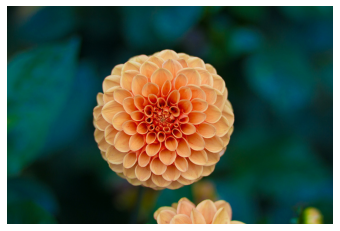

In [40]:
plot_color_image(flower)

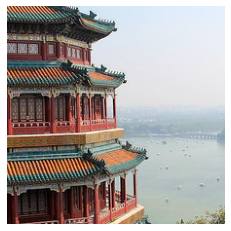

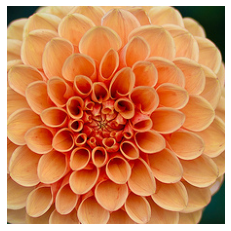

In [41]:
# the resnet-50 model was trained on a different shape so you will need to
# resize the image
# note, here we are cropping and resizing the image

china_resized = tf.image.resize_with_crop_or_pad(china, 224, 224)
flower_resized = tf.image.resize_with_crop_or_pad(flower, 224, 224)

images = np.array([china_resized, flower_resized])

plot_color_image(images[0])
plot_color_image(images[1])

In [42]:
# multiple by 255 as we scaled them when importing 
inputs = keras.applications.resnet50.preprocess_input(images * 255)
Y_proba = resnet_50_model.predict(inputs)

In [43]:
# Resnet has 1,000 classes!!
Y_proba.shape 

(2, 1000)

In [44]:
# use keras decode function
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
top_K

40960/35363 [==================================] - 0s 0us/step


[[('n03877845', 'palace', 0.92317796),
  ('n03781244', 'monastery', 0.053447966),
  ('n02825657', 'bell_cote', 0.009461689)],
 [('n04522168', 'vase', 0.38435292),
  ('n07930864', 'cup', 0.08862832),
  ('n11939491', 'daisy', 0.08091255)]]

The top-3 predictions included the correct answers: Monastery and Daisy, which is pretty good considering it has to predict those from nearly 1,000 classes.

There are many other models in keras, including GoogLeNet variants and light weight models for mobile applications. 

# Pretrained Models for Transfer Learning

The standard off the shelf models are great but what if you needed something more specific? Then Transfer Learning is probably what you need.

If you do not have enough training data then using Transfer Learning alongside some data augmentation will help build a a decent model.



In [45]:
import tensorflow_datasets as tfds

(train_ds, validation_ds, test_ds), info = tfds.load(
    "cats_vs_dogs",
    split=["train[:80%]", "train[80%:90%]", "train[90%:]"],
    as_supervised=True, with_info=True)

num_examples = info.splits['train'].num_examples #  23,262
class_names = info.features['label'].names #  ['cat', 'dog']
n_classes = info.features['label'].num_classes #  2

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete6CX8YH/cats_vs_dogs-train.tfrecord


Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


Note: if you wanted to add data augmentation then you would change the `preprocess` function below.

The `keras.preprocessing.image.ImageDataGenerator` is a great way to load images and then augment them in various ways. You can load images from the directory 

#### Introduce Data Augmentation

Adding the layer on top of the existing model.

In [46]:
# Using the Xception model which expects 224x224 input images
# we now need to resize the images.

def preprocess(image, label):
  resized_image = tf.image.resize(image, [224, 224])
  # run through Xceptions preprocess_input function
  final_image = keras.applications.xception.preprocess_input(resized_image)
  return final_image, label

In [47]:
# # apply this to all datasets

batch_size = 32
train_set = train_ds.shuffle(1000)
train_set = train_ds.map(preprocess).batch(batch_size).prefetch(1)
valid_set = validation_ds.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_ds.map(preprocess).batch(batch_size).prefetch(1)

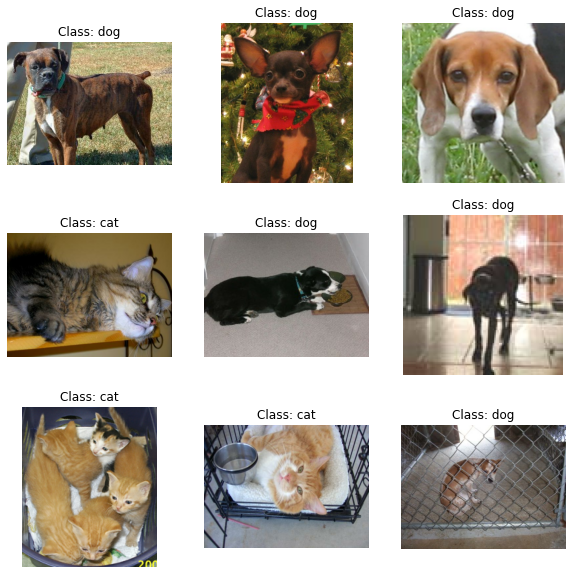

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

In [49]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
# Freeze the base_model
base_model.trainable = False

avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

83689472/83683744 [==============================] - 1s 0us/step


In [50]:
# note the larger learning rate so we can converge with fewer epochs.
optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.7 * num_examples / batch_size),
                    validation_data= valid_set,
                    validation_steps=int(0.1 * num_examples / batch_size),
                    epochs=1) #  change to 5 - will take a long time

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


508/508 [==============================] - 3172s 6s/step - loss: 0.0947 - accuracy: 0.9851 - val_loss: 0.0930 - val_accuracy: 0.9861


Note how the validation score will start to converge. At this point you stop training as the top layers are well trained. 

In [52]:
# now make base model trainable with a reduced learning rate
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * num_examples / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * num_examples / batch_size),
                    epochs=10) # change to 40 to see convergence - will take a long time

Epoch 1/10
545/545 [==============================] - ETA: 0s - loss: 0.0621 - accuracy: 0.9782 WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 109 batches). You may need to use the repeat() function when building your dataset.


545/545 [==============================] - 15474s 28s/step - loss: 0.0621 - accuracy: 0.9782 - val_loss: 0.0411 - val_accuracy: 0.9854
Epoch 2/10
 37/545 [=>............................] - ETA: 3:56:34 - loss: 0.0257 - accuracy: 0.9906WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 5450 batches). You may need to use the repeat() function when building your dataset.


545/545 [==============================] - 1034s 2s/step - loss: 0.0257 - accuracy: 0.9906


The model reaches a fairly good accuracy when classifying pictures of dogs and cats. 

# Classification and Localization

Classifiying an object is great but what if you want to know where the object is located within the image. 

Finding the location of an object can be thought of as a regression task. We need to add another dense output layer with 4 units (no softmax function) and trained using MSE loss - but you can even have IOU loss, as we will see later. 

The 4 outputs will prediction: horizontal and vertical coordinates of the object's center and the height and width. 

The labelling process can be costly but fortunately, there are many tools available, such as, `VGG Image`, `Annotator`, `LabelImg`, `OpenLabeler` `ImgLab` or even commercial tools like Amazon Mechanical Turk. 

### Bounding boxes around Flowers

As you know, with machine learning there needs to be something you learn from. If we are trying to predict bounding boxes then we need a dataset that has bounding boxes around them. 

Lets create a fake dataset with the shape: `(images, (class_labels, bounding_boxes))`. 



In [53]:
# download flowers dataset
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)
class_names = ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']
n_classes = 5
dataset_size = 3670

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [54]:
def add_random_bounding_boxes(images, labels):
    fake_bboxes = tf.random.uniform([tf.shape(images)[0], 4])
    return images, (labels, fake_bboxes)

batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

fake_train_set = train_set.take(5).repeat(2).map(add_random_bounding_boxes)

In [55]:
# build model

base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = keras.layers.Dense(n_classes, activation="softmax")(avg)
loc_output = keras.layers.Dense(4)(avg)
model = keras.models.Model(inputs=base_model.input,
                           outputs=[class_output, loc_output])

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)

model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[0.8, 0.2], # depends on what you care most about
              optimizer=optimizer, metrics=["accuracy"])

In [56]:
model.fit(fake_train_set, steps_per_epoch=5, epochs=2)

Epoch 1/2
5/5 [==============================] - 143s 27s/step - loss: 1.3130 - dense_4_loss: 1.5188 - dense_5_loss: 0.4900 - dense_4_accuracy: 0.3187 - dense_5_accuracy: 0.2375
Epoch 2/2
5/5 [==============================] - 139s 28s/step - loss: 1.1098 - dense_4_loss: 1.3360 - dense_5_loss: 0.2051 - dense_4_accuracy: 0.5000 - dense_5_accuracy: 0.2250


## Intersection over Union (IOU)

Althought MSE works well, bounding box coordinates should be normalized from 0 to 1 and predicting the square root of the height and width. This is prevent larger bounding boxes becoming more penalized than smaller bounding boxes. 

However, another metric that can be used is the Intersection over Union (IoU). The area that overlaps between the predicted bounding box and target bounding box divided by the their union. 
` (Intersection area between prediction box & target box) / union`
This value should approach 1 if the value was perfect. Use `tf.keras.metrics.MeanIoU`.







# Object Detection

**What if an image contained multiple objects and we need to predict their locations?**

Before the faster method of Fully Convolutional Networks, discussed below, to detect multiple images the solutions involved sliding a CNN through the whole image multiple times. Where the image would be split up into regions and the CNN would look and predict on a subset of the image, for example a 3x3 region. As objects can have different scales the CNN may slide across 4x4 regions as well.

Although this method requires running the CNN through the image multiple times and at different scales it works well. However, as you might have guess, it is slow. 

The output of running the CNN multiple times is that multiple boxes are produced. We now need to eliminate these boxes into, ideally, one box per object detect. We use the **Non-Max Suppression** method:

1. Add an extra objectness out to the CNN. This is an estimate that the object is indeed within the image, think of it like a confidence metric. The sigmoid function should be used where a threshold can be set to remove boxes below that threshold, dropping all bounding boxes that do not actually contain the object.

2. Keep the boxes with highest objectness score and get rid of boxes that overlap using the IoU, boxes with an IoU of 60% of each other. 

3. Repeat step 2. until no more bounding boxes are present. 

## Fully Convolutional Networks

The idea of a FCN was first introduced for semantic segmentation. The task of classifiying every pixel according to the class of the object it belongs to. 

It replaces the dense at the top of the network with convolutional layers. 

The weights of the convolutional layer will be identical to the dense layers produced, the only difference is the tensor shape. It went from `[batch_size, 200]` to `[batch_size, 1, 1, 200]` (if the kernel size is 1x1). 

In summary, to convert the dense layer to a convolutional layer set the number of filters to the number of units in the dense layer. With the filter size equal to the input feature maps (and valid padding). 

Think about it. The weights for each neuron for a dense layer is unique. While the weight for each feature map is different for a convolutional layer. Because of this a FCN can take an image of any input size, unlike a dense layer. 

The FCN only needs to look at the image once! Which moves us onto the You Only Look Once detection architecture.

## You Only Look Once (YOLO)

YOLO is extremely fast and can be used to detect objects in real time. It is very similiar to the fully convolutional network architecture with a few modifications: 

1. It predicts 5 bounding boxes per cell plus 5 objectness scores for each. 20 class probabilities (because it is trained on PACAL VOC dataset - which contains 20 classes). Therefore, for each cell it predcits 45 numbers: 5 bounding boxes with 4 coordinates each, 5 objectness scores and 20 class probabilities.

2. The predicted coordinates use the offset relative to the coordinates of the grid cell, meaning (0, 0) is top left and (1, 1) is bottom right of the cell - NOT absolute coordinates. YOLO is trained on bounding boxes whose centres lay on that cell, even though the bounding box sizes extend far beyond that cell. 

3. Applies K-Means algorithm to find 5 representative anchor boxes. For example, if a training set contains multiples pedestrians then an anchor box would be the same size as a pedestrian. Without going into the detail, the network predicts the log of the scaling vertical and horizontal factors. This allows the network to learn reasonable bounding boxes.   


4. The network randomly uses images of different scales every few batches during training. This allows the network to learn objects at different scales. Smaller images will be less accurate but larger images will be slower. 


### Mean Average Precision (mAP)

The mAP is used in object detection tasks. As mentioned, detecting an object in an image is a classification task. So we can use metrics such as precision and recall. Remember that these values have a trade-off so often you would have to "pick" which metric to optimize to. You could also use the area under the curve (AUC) but often there are sharp variations in this curve. For example, a model could have a 90% precision and 10% recall but 96% precision at 20% recall.

Clearly, the later is a better option. A good way to get an idea of how good a model is compute the maximum precision at multiple recall values. We can then calculate the mean of these values called the *Average Precision* metric. 

<br/>

#### YOLO9000
This model uses hierachical classification by taking advantage of a Word Tree. Where the model predicts the probability for each node within the tree. For example, the model may not be able accurately be able to predict the type of dog but it will have high confidence that it is a dog.


#### Single Shot Detection (SSD) and Faster-RCNN

A Single shot model is similiar to YOLO. 

A Faster RCNN is more complex: image goes through a CNN then outputs a Region Proposal Network (RPN) that proposes bounding boxes and then runs a classifier for each bounding box.

## Summary

The network architectures and metrics are changing very quickly but it also depends on the demands (i.e. speed, accuracy, available pre-trained models, training time, complexity etc.).

However, what if you want more than boxes. What if you want pixel level detail. You would use Semantic Segmentation.

#### mAP with Intersection Over Union Metric

With object detection, we also need to know the location of the object. So we can define an IOU threshold where the prediction is only correct when above this value.

Notation being: `mAP@0.5`, which represents a mAP score where the threshold value is above 50%. 


# Semantic Segmentation

Semantic segmentation classifies each pixel according to the class of the object that it belongs to (for example, road, pavement, person, building etc.), however, the downside is that it groups these objects together as one segment. For example, a group of people would be grouped together as a people segment. For instance level detection you would use **Instance Segmentation**, where each people will be recognised as an individual person rather than a segment.  

The problem with regular CNNs are that spatial resolution gets disorted, due to the strides within the layers. One simple solution, similiar to object detection, is to connect a fully convolutional network ontop of a trained CNN. However, the output of this is smaller than the input image. We can no introduce an upsampling layer to multiple the resolution back to the original input image. 

One way to upsample an image is to use a Transposed Convolutional Layer, but but this method is too imprecise so a skip connection was added. The skip connection affectively creates a connection from lowers layers to the upscaling. Using this method we gain spatial resolution. We even have the potenial to increase resolution beyond the input image with a technique called super-resolution. 


### Transposed Convolutional Layer 
This is how it works: 
1. The image is first stretched and a bunch of zeros along the rows and columns.

2. Perform a regular convolutional layer that uses fractional strides (i.e. 1/3).

3. It is a trainable layer so it will do better during training when compared to linear interpolation. 

In `tr.keras.Conv2DTranspose` layers the `stride` represents how much the input will be stretched. 


# Summary

That was a lot to take in but hopefully it gives a great overview of the types of networks are being used for Computer Vision problems. This field is fast growing and new architectures are coming out every year trying to solve more problems. 